In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import os
from glob import glob
import cv2
import imageio
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
DIR_LIST =['augmented_data/train_org/',
           'augmented_data/train_sr/HR',
           'augmented_data/train_sr/LRBICUBIC',
           'augmented_data/train_sr/LRX2',
           'save_model']
               
for dir in DIR_LIST:
    os.makedirs(dir, exist_ok=True)  
    
DATA_DIR = ['data/bsd200', 'data/yang91']
OUTPUT_DIR = 'augmented_data/train_org/'

BICUBIC_DIR = 'augmented_data/train_sr/LRBICUBIC'
LRX2_DIR = 'augmented_data/train_sr/LRX2'
HR_DIR = 'augmented_data/train_sr/HR'

TEST_DIR = 'data/set5'
TEST_OUTPUT_DIR = 'test/'
MODEL_PATH = 'save_model/WAZIR_V2_e100_lr0.0001.pt'

SCALE_FACTOR = 2

In [3]:
def generateAugmentedImg(file_list):
    
    img_org = cv2.imread(file_list[0])
    # original image
    
    img_0 = img_org
    path_0 = file_list[2] + "img_" + str(file_list[1]) + "_0" + ".png"
    cv2.imwrite(path_0, img_0)
    # original image
    
    img_1 = np.flipud(img_org)
    path_1 = file_list[2] + "img_" + str(file_list[1]) + "_1"  + ".png"
    cv2.imwrite(path_1, img_1)
    # flip vertical
    
    img_2 = np.fliplr(img_org)
    path_2 = file_list[2] + "img_" + str(file_list[1]) + "_2"  + ".png"
    cv2.imwrite(path_2, img_2)
    # flip horizontal
    
    img_3 = np.fliplr(np.flipud(img_org))
    path_3 = file_list[2] + "img_" + str(file_list[1]) + "_3"  + ".png"
    cv2.imwrite(path_3, img_3)
    # flip vertical - horizontal
    
    img_4 = np.rot90(img_org)
    path_4 = file_list[2] + "img_" + str(file_list[1]) + "_4"  + ".png"
    cv2.imwrite(path_4, img_4)
    # rotation 90 degree(CCW)
    
    img_5 = np.rot90(img_org, -1)
    path_5 = file_list[2] + "img_" + str(file_list[1]) + "_5"  + ".png"
    cv2.imwrite(path_5, img_5)
    # rotation 270 degree(CCW)
    
    img_6 = np.flipud(np.rot90(img_org))
    path_6 = file_list[2] + "img_" + str(file_list[1]) + "_6"  + ".png"
    cv2.imwrite(path_6, img_6)
    # rotation 90 degree(CCW) - flip vertical

    img_7 = np.flipud(np.rot90(img_org, -1))
    path_7 = file_list[2] + "img_" + str(file_list[1]) + "_7"  + ".png"
    cv2.imwrite(path_7, img_7)
    # rotation 270 degree(CCW) - flip vertical

# 데이터 - 증강

In [4]:
file_list = []
file_num = 0

for i in DATA_DIR:
    for j, file in enumerate(sorted(glob(i + '/*'))):
        file_list.append([file, file_num, OUTPUT_DIR])
        file_num += 1
        
print(len(file_list), "original image loaded")
# load original image


for i in range(len(file_list)):
    generateAugmentedImg(file_list[i])
    # generate Augmented images
    
print("augmented image genarated")

12 original image loaded
augmented image genarated


# 데이터 - HR, LR, BI 생성

In [5]:
def cvtBGR2Y(image):

    R = image[:,:,2]
    G = image[:,:,1]
    B = image[:,:,0]
    
    # Y' = 16  +  65.481  * R' + 128.553  * G' +  24.966  * B'
    Y = (16*255.0/256.0)  + (65.481/256.0*R +  128.553/256.0*G +  24.966/256.0*B)
    # convert cv2 BGR image to Y(CbCr) image
        
    return Y

In [6]:
def resizeImage(image, scale):
    
    width, height = image.shape[1], image.shape[0]
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    image = Image.fromarray(image.reshape(height, width))
    image = image.resize([new_width, new_height], Image.BICUBIC)
    image = np.asarray(image)
    image = image.reshape(new_height, new_width)
    return image

In [7]:
def splitPatches(image, window_size, stride):
 
    size = image.itemsize
    # image item size
    
    shape = (1 + (image.shape[0] - window_size) // stride,
            1 + (image.shape[1] - window_size) // stride,
             window_size,
             window_size)
    strides = size * np.array([image.shape[1] * stride, stride, image.shape[1], 1])
             
    return np.lib.stride_tricks.as_strided(image, shape, strides)

In [8]:
def getImgPatches(image, window_size, stride):

    patches = splitPatches(image, window_size, stride)
    # split images into patches(sliding window)
    
    patches = patches.reshape(patches.shape[0] * patches.shape[1], 1, patches.shape[2], patches.shape[3])
    # reshape patches
    
    height, width = image.shape[0], image.shape[1]
    
    extra_patches = []
    if (image.shape[0] - window_size) % stride != 0:
        for x in range(0, image.shape[1] - window_size, stride):
            extra_patches.append(image[image.shape[0] - window_size - 1:image.shape[0] - 1, x:x + window_size:])

    if (width - window_size) % stride != 0:
        for y in range(0, image.shape[0] - window_size, stride):
            extra_patches.append(image[y: y + window_size, image.shape[1] - window_size - 1:image.shape[1] - 1])

    if len(extra_patches) > 0:
        org_size = patches.shape[0]
        patches = np.resize(patches, [org_size + len(extra_patches), patches.shape[1], patches.shape[2], patches.shape[3]])
        for i in range(len(extra_patches)):
            extra_patches[i] = extra_patches[i].reshape([1,extra_patches[i].shape[0], extra_patches[i].shape[1]])
            patches[org_size + i] = extra_patches[i]
    
    return patches

In [9]:
def getPatchList(train_list, HR_DIR, LRX2_DIR, BICUBIC_DIR):
    
    patch_size = 32
    patch_stride = 16
    # lr patch size
    
    patch_hr_size = patch_size * SCALE_FACTOR
    patch_hr_stride = patch_stride * SCALE_FACTOR
    # hr, bi patch size

    hr_list = []
    lr_list = []
    bi_list = []

    for image_path in train_list:
        image = cv2.imread(image_path)
        # load image(BGR)
        
        width, height = (image.shape[1]//SCALE_FACTOR) * SCALE_FACTOR, (image.shape[0]//SCALE_FACTOR)*SCALE_FACTOR
        hr_img = image[:height, :width, 0:3]
        # Adjust the image size to a multiple of SCALE_FACTOR.
        
        hr_y = cvtBGR2Y(hr_img)
        lr_y = resizeImage(hr_y, 1/SCALE_FACTOR)
        bi_y = resizeImage(lr_y, SCALE_FACTOR)
        
        #lr_y = cv2.resize(hr_y, dsize=(0, 0), fx=(1/SCALE_FACTOR), fy=(1/SCALE_FACTOR), interpolation=cv2.INTER_CUBIC)
        #bi_y = cv2.resize(lr_y, dsize=(0, 0), fx=SCALE_FACTOR, fy=SCALE_FACTOR, interpolation=cv2.INTER_CUBIC)
        # convert image to Y image, resize into lr & bi
        # cv2 resize function result is not same with PIL resize!!!
                
        hr_y_patches = getImgPatches(hr_y, patch_hr_size, patch_hr_stride)
        lr_y_patches = getImgPatches(lr_y, patch_size, patch_stride)
        bi_y_patches = getImgPatches(bi_y, patch_hr_size, patch_hr_stride)
        # split hr, lr, bi into patches
              
        hr_list.append(hr_y_patches)
        lr_list.append(lr_y_patches)
        bi_list.append(bi_y_patches)
        # append hr. lr, bi Y patches into list
        
    hr_array = np.concatenate(hr_list)
    lr_array = np.concatenate(lr_list)
    bi_array = np.concatenate(bi_list)
    # concatenate list into array  (2328*[num_patches,1,patch_size,patch_size]) --> (2328*num_patches,1,patch_size,patch_size)

    return hr_array, lr_array, bi_array 

In [10]:
train_list = []

for i in (sorted(glob(OUTPUT_DIR + '/*'))):
        train_list.append(i)

HR_ARRAY, LR_ARRAY, BI_ARRAY = getPatchList(train_list, HR_DIR, LRX2_DIR, BICUBIC_DIR)
# split train images --> hr, lr, bi patches

# 데이터셋 생성

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, hr_array, lr_array, bi_array, transform=None):
        self.hr_array = hr_array
        self.lr_array = lr_array
        self.bi_array = bi_array
        
    def __len__(self):
        return len(self.hr_array)
        
    def __getitem__(self, index):
        hr = self.hr_array[index]
        lr = self.lr_array[index]
        bi = self.bi_array[index]
        
        return hr, lr, bi

In [12]:
train_dataset = CustomDataset(HR_ARRAY, LR_ARRAY, BI_ARRAY)

# 모델 생성

![nn](./figure1_v2.png)

In [13]:
class WAZIR(nn.Module):
    
    def __init__(self, kernel_size = 3, n_channels = 64):
        super(WAZIR, self).__init__()
                
        # common layer
        self.drop = nn.Dropout(p=0.8)
        #self.prelu = nn.PReLU()
        self.leakyrelu = nn.LeakyReLU(0.2)
        
        # feature extraction layer
        self.conv1 = nn.Conv2d(1, 196, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv2 = nn.Conv2d(196, 166, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv3 = nn.Conv2d(166, 148, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv4 = nn.Conv2d(148, 133, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv5 = nn.Conv2d(133, 120, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv6 = nn.Conv2d(120, 108, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv7 = nn.Conv2d(108, 97, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv8 = nn.Conv2d(97, 86, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv9 = nn.Conv2d(86, 76, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv10 = nn.Conv2d(76, 66, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv11 = nn.Conv2d(66, 57, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv12 = nn.Conv2d(57, 66, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        self.conv13 = nn.Conv2d(66, 57, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv14 = nn.Conv2d(120, 108, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv15 = nn.Conv2d(108, 97, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv16 = nn.Conv2d(97, 86, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv17 = nn.Conv2d(86, 76, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv18 = nn.Conv2d(76, 66, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv19 = nn.Conv2d(66, 57, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        #self.conv20 = nn.Conv2d(57, 48, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        
        ## he initialization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        nn.init.kaiming_normal_(self.conv13.weight)
        #nn.init.kaiming_normal_(self.conv14.weight)
        #nn.init.kaiming_normal_(self.conv15.weight)
        #nn.init.kaiming_normal_(self.conv16.weight)
        #nn.init.kaiming_normal_(self.conv17.weight)
        #nn.init.kaiming_normal_(self.conv18.weight)
        #nn.init.kaiming_normal_(self.conv19.weight)
        #nn.init.kaiming_normal_(self.conv20.weight)

        
        # reconstruction layer
        self.A1 = nn.Conv2d(1376, 64, 1, stride = 1, bias = True)
        self.B1 = nn.Conv2d(1376, 32, 1, stride = 1, bias = True)
        self.B2 = nn.Conv2d(32, 32, kernel_size, stride = 1, padding=1,padding_mode="replicate",bias=True)
        
        ## he initialization
        nn.init.kaiming_normal_(self.A1.weight)
        nn.init.kaiming_normal_(self.B1.weight)
        nn.init.kaiming_normal_(self.B2.weight)
        
        # feature extraction layer
        self.UPsample = nn.Conv2d(96, 2*2*96, kernel_size, stride = 1, padding =1, padding_mode = "replicate", bias = True)
        self.pixelshuffle = nn.PixelShuffle(2)
        
        self.R = nn.Conv2d(96, 1, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = True)
        
        ## he initialization
        nn.init.kaiming_normal_(self.UPsample.weight)
        nn.init.kaiming_normal_(self.R.weight)
        
    def forward(self, x):
                
        # feature extraction network
        skip1 = self.drop(self.leakyrelu(self.conv1(x)))
        skip2 = self.drop(self.leakyrelu(self.conv2(skip1)))
        skip3 = self.drop(self.leakyrelu(self.conv3(skip2)))
        skip4 = self.drop(self.leakyrelu(self.conv4(skip3)))
        skip5 = self.drop(self.leakyrelu(self.conv5(skip4)))
        skip6 = self.drop(self.leakyrelu(self.conv6(skip5)))
        skip7 = self.drop(self.leakyrelu(self.conv7(skip6)))
        skip8 = self.drop(self.leakyrelu(self.conv8(skip7)))
        skip9 = self.drop(self.leakyrelu(self.conv9(skip8)))
        skip10 = self.drop(self.leakyrelu(self.conv10(skip9)))
        skip11 = self.drop(self.leakyrelu(self.conv11(skip10)))
        skip12 = self.drop(self.leakyrelu(self.conv12(skip11)))
        skip13 = self.drop(self.leakyrelu(self.conv13(skip12)))
        #skip14 = self.drop(self.leakyrelu(self.conv14(skip13)))
        #skip15 = self.drop(self.leakyrelu(self.conv15(skip14)))
        #skip16 = self.drop(self.leakyrelu(self.conv16(skip15)))
        #skip17 = self.drop(self.leakyrelu(self.conv17(skip16)))
        #skip18 = self.drop(self.leakyrelu(self.conv18(skip17)))
        #skip19 = self.drop(self.leakyrelu(self.conv19(skip18)))
        #skip20 = self.drop(self.leakyrelu(self.conv20(skip19)))
        
        # reconstruction network
        recon_input = torch.cat([skip1, skip2, skip3, skip4, skip5, skip6, skip7, skip8, skip9, skip10, skip11, skip12,skip13], dim = 1)
        
        A1_out = self.drop(self.leakyrelu(self.A1(recon_input)))
        
        B1_out = self.drop(self.leakyrelu(self.B1(recon_input)))
        B2_out = self.drop(self.leakyrelu(self.B2(B1_out)))
        
        recon_output = torch.cat([A1_out, B2_out], dim = 1)
        
        # up-sampling network
        UPsample_out = self.drop(self.pixelshuffle(self.UPsample(recon_output)))
        R_out = self.R(UPsample_out)
        
        return R_out
model = WAZIR()
print(model)

WAZIR(
  (drop): Dropout(p=0.8, inplace=False)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (conv1): Conv2d(1, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv2): Conv2d(196, 166, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv3): Conv2d(166, 148, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv4): Conv2d(148, 133, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv5): Conv2d(133, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv6): Conv2d(120, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv7): Conv2d(108, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv8): Conv2d(97, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv9): Conv2d(86, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode

# 하이퍼 파라미터

In [14]:
learning_rate = 1e-4
num_epochs = 4
BATCH_SIZE  = 20
model_path = 'save_model'

In [15]:
data_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=True
    )

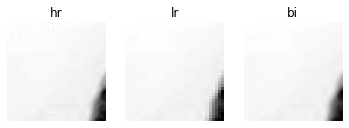

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
rows = 1
cols = 3

for hr, lr, bi in data_loader:
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr[0][0], cmap='gray')
    ax1.set_title('hr')
    ax1.axis("off")

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(lr[0][0], cmap='gray')
    ax2.set_title('lr')
    ax2.axis("off")

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(bi[0][0], cmap='gray')
    ax3.set_title('bi')
    ax3.axis("off")

    plt.show()
    break

In [17]:
for hr, lr, bi in data_loader:
    print(hr[0][0])
    print(lr[0][0])
    print(bi[0][0])
    break

tensor([[232.4224, 232.4224, 232.4224,  ..., 229.0005, 229.0005, 229.0005],
        [232.4224, 232.4224, 232.4224,  ..., 228.1451, 228.1451, 228.1451],
        [232.4224, 232.4224, 232.4224,  ..., 228.1451, 228.1451, 228.1451],
        ...,
        [228.1451, 228.1451, 228.1451,  ..., 100.3783,  95.1385,  88.0997],
        [228.1451, 228.1451, 228.1451,  ...,  90.7679,  90.5635,  89.0014],
        [228.1451, 228.1451, 228.1451,  ...,  82.3202,  87.4436,  90.9168]],
       dtype=torch.float64)
tensor([[232.4012, 232.6317, 232.8710,  ..., 228.6811, 228.2615, 228.5630],
        [232.3953, 232.6944, 232.9943,  ..., 228.7823, 228.3149, 228.1042],
        [232.5037, 232.0092, 231.5407,  ..., 229.1756, 228.7800, 228.0836],
        ...,
        [228.1827, 227.7776, 227.3360,  ..., 126.6217,  99.8756,  86.3969],
        [228.1890, 227.7123, 227.2287,  ..., 115.7896, 101.3014,  89.6323],
        [228.2702, 227.7822, 227.2912,  ...,  95.3908,  86.5292,  89.0847]])
tensor([[232.3819, 232.4392, 232

# 모델 로드 & 학습

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = WAZIR().to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.MSELoss().to(device)

for epochs in range(num_epochs):  
    
    for HR, LR, BI in data_loader:
                   
        recon = model(LR.to(device).float())
        recon += BI.to(device).float()
        loss = loss_func(recon, HR.to(device).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch: {}, Loss: {}, LR: {}'.format(epochs+1, loss.item(), learning_rate))
    ##############if epoch % 10 == 0:
    if epochs % 2 == 0:
        save_model_path = model_path + "/WAZIR_V2_e{}_lr{}_loss{:4}.pt".format(epochs, learning_rate, loss.item())
        torch.save(model, save_model_path)
        print("Epoch {} model saved.".format(epochs+1))
        # save model per 10 epochs

save_model_path = model_path + "/WAZIRN_V2_e{}_lr{}.pt".format(epochs+1, learning_rate)
torch.save(model, save_model_path)
print("EPOCH {} last model saved.".format(epochs+1))
# save last model

WAZIR(
  (drop): Dropout(p=0.8, inplace=False)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (conv1): Conv2d(1, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv2): Conv2d(196, 166, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv3): Conv2d(166, 148, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv4): Conv2d(148, 133, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv5): Conv2d(133, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv6): Conv2d(120, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv7): Conv2d(108, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv8): Conv2d(97, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv9): Conv2d(86, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode

# 테스트

평가 코드는 공정성을 위해 레퍼런스 코드 그대로 이용

evaluation notebook 참조

In [19]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|   conv1.weight  |    1764    |
|    conv1.bias   |    196     |
|   conv2.weight  |   292824   |
|    conv2.bias   |    166     |
|   conv3.weight  |   221112   |
|    conv3.bias   |    148     |
|   conv4.weight  |   177156   |
|    conv4.bias   |    133     |
|   conv5.weight  |   143640   |
|    conv5.bias   |    120     |
|   conv6.weight  |   116640   |
|    conv6.bias   |    108     |
|   conv7.weight  |   94284    |
|    conv7.bias   |     97     |
|   conv8.weight  |   75078    |
|    conv8.bias   |     86     |
|   conv9.weight  |   58824    |
|    conv9.bias   |     76     |
|  conv10.weight  |   45144    |
|   conv10.bias   |     66     |
|  conv11.weight  |   33858    |
|   conv11.bias   |     57     |
|  conv12.weight  |   33858    |
|   conv12.bias   |     66     |
|  conv13.weight  |   33858    |
|   conv13.bias   |     57     |
|    A1.weight    |   88064    |
|     A1.b

1803881

In [20]:
import numpy as np
import os
from PIL import Image
import imageio
from glob import glob
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [21]:
def load_img(OUTPUT_DIR,expected_totalaug=0,test=False):

    split_list = []
    for i in (sorted(glob(OUTPUT_DIR + '/*'))):
        split_list.append(i)

    if test:
        pass
    else:
        if len(split_list) != expected_totalaug:
            print("Not fittable the number of augmented images !!")
            exit()
        else:
            print("Next Level : Split images Using Window, {} pic".format(len(split_list)))

    return split_list

def resize_image_by_pil(image, scale):
    width, height = image.shape[1], image.shape[0]
    new_width = int(width * scale)
    new_height = int(height * scale)
    method = Image.BICUBIC

    if len(image.shape) == 3 and image.shape[2] == 3:
        image = Image.fromarray(image, "RGB")
        image = image.resize([new_width, new_height], resample=method)
        image = np.asarray(image)
    elif len(image.shape) == 3 and image.shape[2] == 4:
        # the image may has an alpha channel
        image = Image.fromarray(image, "RGB")
        image = image.resize([new_width, new_height], resample=method)
        image = np.asarray(image)
    else:
        image = Image.fromarray(image.reshape(height, width))
        image = image.resize([new_width, new_height], resample=method)
        image = np.asarray(image)
        image = image.reshape(new_height, new_width, 1)
    return image


def save_image(filename, image, print_console=True):
    if len(image.shape) >= 3 and image.shape[0] == 1:
        image = image.reshape(image.shape[1], image.shape[2])

    directory = os.path.dirname(filename)
    if directory != "" and not os.path.exists(directory):
        os.makedirs(directory)

    image = image.astype(np.uint8)
    if len(image.shape) >= 3 and image.shape[0] == 3:
        image = Image.fromarray(image, mode="RGB")
    else:
        image = Image.fromarray(image)
    imageio.imwrite(filename, image)

    if print_console:
        print("Saved [%s]" % filename)


def set_image_alignment(image, alignment):
    alignment = int(alignment)
    width, height = image.shape[1], image.shape[0]
    width = (width // alignment) * alignment
    height = (height // alignment) * alignment

    if image.shape[1] != width or image.shape[0] != height:
        image = image[:height, :width, :]

    if len(image.shape) >= 3 and image.shape[2] >= 4:
        image = image[:, :, 0:3]

    return image

def convert_rgb_to_y(image, jpeg_mode=False, max_value=255.0):
    if len(image.shape) <= 2 or image.shape[2] == 1:
        return image

    if jpeg_mode:
        xform = np.array([[0.299, 0.587, 0.114]])
        y_image = image.dot(xform.T)
    else:
        xform = np.array([[65.481 / 256.0, 128.553 / 256.0, 24.966 / 256.0]])
        y_image = image.dot(xform.T) + (16.0 * max_value / 256.0)

    return y_image

def convert_rgb_to_ycbcr(image):
    if len(image.shape) < 2 or image.shape[2] == 1:
        return image

    xform = np.array(
        [[65.738 / 256.0, 129.057 / 256.0, 25.064 / 256.0],
         [- 37.945 / 256.0, - 74.494 / 256.0, 112.439 / 256.0],
         [112.439 / 256.0, - 94.154 / 256.0, - 18.285 / 256.0]])

    ycbcr_image = image.dot(xform.T)
    ycbcr_image[:, :, 0] += 16.0
    ycbcr_image[:, :, [1, 2]] += 128.0

    return ycbcr_image


def convert_y_and_cbcr_to_rgb(y_image, cbcr_image):
    print(cbcr_image.shape)
    if len(y_image.shape) <= 2:
        y_image = y_image.reshape[y_image.shape[0], y_image.shape[1], 1]

    if len(y_image.shape) == 3 and y_image.shape[2] == 3:
        y_image = y_image[:, :, 0:1]

    ycbcr_image = np.zeros([y_image.shape[0], y_image.shape[1], 3])
    ycbcr_image[:, :, 0] = y_image[:, :, 0]
    ycbcr_image[:, :, 1:3] = cbcr_image[:, :, 0:2]

    return convert_ycbcr_to_rgb(ycbcr_image)

def convert_ycbcr_to_rgb(ycbcr_image):
    rgb_image = np.zeros([ycbcr_image.shape[0], ycbcr_image.shape[1], 3])  # type: np.ndarray

    rgb_image[:, :, 0] = ycbcr_image[:, :, 0] - 16.0
    rgb_image[:, :, [1, 2]] = ycbcr_image[:, :, [1, 2]] - 128.0
    xform = np.array(
        [[298.082 / 256.0, 0, 408.583 / 256.0],
         [298.082 / 256.0, -100.291 / 256.0, -208.120 / 256.0],
         [298.082 / 256.0, 516.412 / 256.0, 0]])
    rgb_image = rgb_image.dot(xform.T)

    return rgb_image
def get_split_images(image, window_size, stride=None, enable_duplicate=True):
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image.reshape(image.shape[0], image.shape[1])
    #print(image.shape)
    window_size = int(window_size)
    size = image.itemsize
    height, width = image.shape
    if stride is None:
        stride = window_size
    else:
        stride = int(stride)

    if height < window_size or width < window_size:
        return None

    new_height = 1 + (height - window_size) // stride
    new_width = 1 + (width - window_size) //  stride

    shape = (new_height, new_width, window_size, window_size)
    strides = size * np.array([width * stride, stride, width, 1])
    windows = np.lib.stride_tricks.as_strided(image, shape=shape, strides=strides)


    windows = windows.reshape(windows.shape[0] * windows.shape[1],1, windows.shape[2], windows.shape[3])

    if enable_duplicate:
        extra_windows = []
        if (height - window_size) % stride != 0:
            for x in range(0, width - window_size, stride):
                extra_windows.append(image[height - window_size - 1:height - 1, x:x + window_size:])

        if (width - window_size) % stride != 0:
            for y in range(0, height - window_size, stride):
                extra_windows.append(image[y: y + window_size, width - window_size - 1:width - 1])

        if len(extra_windows) > 0:
            org_size = windows.shape[0]
            windows = np.resize(windows,
                                [org_size + len(extra_windows), windows.shape[1], windows.shape[2], windows.shape[3]])
            for i in range(len(extra_windows)):
                extra_windows[i] = extra_windows[i].reshape([1,extra_windows[i].shape[0], extra_windows[i].shape[1]])
                windows[org_size + i] = extra_windows[i]

    return windows

def GPU_AVAILABLE():
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('Device:', device)  # 출력결과: cuda
    print('Count of using GPUs:', torch.cuda.device_count())  # 출력결과: 2 (2, 3 두개 사용하므로)
    print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)
    return device

def compute_psnr_and_ssim(image1, image2, border_size=0):
    """
    Computes PSNR and SSIM index from 2 images.
    We round it and clip to 0 - 255. Then shave 'scale' pixels from each border.
    """
    if len(image1.shape) == 2:
        image1 = image1.reshape(image1.shape[0], image1.shape[1], 1)
    if len(image2.shape) == 2:
        image2 = image2.reshape(image2.shape[0], image2.shape[1], 1)

    if image1.shape[0] != image2.shape[0] or image1.shape[1] != image2.shape[1] or image1.shape[2] != image2.shape[2]:
        return None

    image1 = trim_image_as_file(image1)
    image2 = trim_image_as_file(image2)

    if border_size > 0:
        image1 = image1[border_size:-border_size, border_size:-border_size, :]
        image2 = image2[border_size:-border_size, border_size:-border_size, :]

    psnr = peak_signal_noise_ratio(image1, image2, data_range=255)
    ssim = structural_similarity(image1, image2, win_size=11, gaussian_weights=True, multichannel=True, K1=0.01, K2=0.03,
                        sigma=1.5, data_range=255)
    return psnr, ssim


def trim_image_as_file(image):
    image = np.rint(image)
    image = np.clip(image, 0, 255)
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    return image

In [22]:
# Checking GPU Available

# splited 된 그림을 보길 원하시면 batch_picture_save_flag 를 1 로 바꾸시면 됩니다.
# 경로 : augmented_data/train_sr
batch_picture_save_flag = 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)  # 출력결과: cuda
print('Count of using GPUs:', torch.cuda.device_count())  # 출력결과: 2 (2, 3 두개 사용하므로)
print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)

# Configure Data Augmentation

DATA_DIR = ['data/bsd200', 'data/yang91']
OUTPUT_DIR = 'augmented_data/train_org/'

# Split Parameters

BICUBIC_DIR = 'augmented_data/train_sr/LRBICUBIC'
LRX2_DIR = 'augmented_data/train_sr/LRX2'
HR_DIR = 'augmented_data/train_sr/HR'

lr_batch_size = 32
scale = 2

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [23]:
def test(model_path,lr,bi):

    device = GPU_AVAILABLE()

    if len(lr.shape) == 3 and lr.shape[2] == 1:
        lr_luma = lr.reshape(1,1,lr.shape[0], lr.shape[1])
    if len(bi.shape) == 3 and bi.shape[2] == 1:
        bi_luma = bi.reshape(1,1,bi.shape[0], bi.shape[1])

    lr_luma = torch.FloatTensor(lr_luma).to(device)
    bi_luma = torch.FloatTensor(bi_luma).to(device)
    
    load_model = torch.load(model_path).to(device)
    load_model.eval()

    with torch.no_grad():
        pred = load_model(lr_luma)
        pred += bi_luma

    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(pred.shape[2],pred.shape[3],1)
    return pred

In [24]:
# model load

load_path = 'save_model/WAZIRN_V2_e4_lr0.0001.pt'

# test image load

test_dir = 'data/set5'
test_list = load_img(test_dir,test=True)
scale_factor = 2
output_dir = 'test'

AVG_PSNR = []
AVG_SSIM = []
for i in test_list:
    file_name = os.path.basename(i)
    file_name,ext = os.path.splitext(file_name)

    img = imageio.imread(i)
    lr_img = resize_image_by_pil(img,1/scale_factor)
    bi_img = resize_image_by_pil(lr_img,scale_factor)

    y_img = convert_rgb_to_y(img)
    y_lr_img = resize_image_by_pil(y_img,1/scale_factor)
    y_bi_img = resize_image_by_pil(y_lr_img,scale_factor)
    ycbcr_bi_img = convert_rgb_to_ycbcr(bi_img)

    recon = test(load_path,y_lr_img,y_bi_img)
    recon_rgb = convert_y_and_cbcr_to_rgb(recon,ycbcr_bi_img[:,:,1:3])

    bicubic_rgb = convert_y_and_cbcr_to_rgb(y_bi_img,ycbcr_bi_img[:,:,1:3])

    luma_psnr,luma_ssim = compute_psnr_and_ssim(y_img, recon, 2+scale_factor)
    luma_bipsnr, luma_bissim = compute_psnr_and_ssim(y_img, y_bi_img, 0)

    print("luma_recon : {} / {} luma_bicubic : {} / {}".format(luma_psnr, luma_ssim, luma_bipsnr, luma_bissim))

    org_name = output_dir+file_name + '_org' + ext
    recon_save_name = output_dir+file_name + '_recon' + ext
    bi_save_name = output_dir+file_name + '_bi' + ext

    recon_rgb = np.clip(recon_rgb,0,255)
    bicubic_rgb = np.clip(bicubic_rgb,0,255)

    AVG_PSNR.append(luma_psnr)
    AVG_SSIM.append(luma_ssim)

avg_psnr = sum(AVG_PSNR)/len(AVG_PSNR)
avg_ssim = sum(AVG_SSIM)/len(AVG_SSIM)

print("avg_psnr / avg_ssim : {} / {}".format(avg_psnr,avg_ssim))

Device: cuda
Count of using GPUs: 1
Current cuda device: 0
(512, 512, 2)
(512, 512, 2)
luma_recon : 6.858801401191967 / 0.02795715443789959 luma_bicubic : 37.12439095115347 / 0.9520454406738281


C:\Users\user\AppData\Local\Temp/ipykernel_18204/3298102410.py:206: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim = structural_similarity(image1, image2, win_size=11, gaussian_weights=True, multichannel=True, K1=0.01, K2=0.03,


Device: cuda
Count of using GPUs: 1
Current cuda device: 0
(288, 288, 2)
(288, 288, 2)
luma_recon : 9.66448093705154 / 0.05842145159840584 luma_bicubic : 36.73963134778147 / 0.9719822406768799
Device: cuda
Count of using GPUs: 1
Current cuda device: 0
(256, 256, 2)
(256, 256, 2)
luma_recon : 7.331540814504864 / 0.07528065890073776 luma_bicubic : 27.485831267157707 / 0.9150046706199646
Device: cuda
Count of using GPUs: 1
Current cuda device: 0
(280, 280, 2)
(280, 280, 2)
luma_recon : 10.064846471161948 / 0.06277147680521011 luma_bicubic : 34.90877421068931 / 0.8621172308921814
Device: cuda
Count of using GPUs: 1
Current cuda device: 0
(344, 228, 2)
(344, 228, 2)
luma_recon : 7.314249153296137 / 0.049908727407455444 luma_bicubic : 32.1838099118808 / 0.9474995136260986
Device: cuda
Count of using GPUs: 1
Current cuda device: 0
(276, 276, 2)
(276, 276, 2)
luma_recon : 10.06081707753592 / 0.06257705390453339 luma_bicubic : 34.890131994263214 / 0.8619232177734375
Device: cuda
Count of using 